In [1]:
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
import boto3
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import Point, Polygon
import seaborn as sns
from dotenv import load_dotenv

In [2]:
def make_key():
    return datetime.utcnow().strftime("%Y-%m-%dT%H-%M")
    
def get_recent_data():
    load_dotenv()
    # By latitude and longitude
    # API parameters
    endtime = datetime.utcnow()
    starttime = endtime - timedelta(hours = 0.5)
    
    options = {}
    options["url"] = "https://www.airnowapi.org/aq/data/"
    options["parameters"] = "OZONE,PM25,PM10,CO,NO2,SO2"
    options["bbox"] = "-180,-90, 180,90"
    options["data_type"] = "B"
    options["format"] = "application/json"
    options["ext"] = "json"
    options["API_KEY"] = os.getenv("API_AIRNOW")
    options['includerawconcentrations'] = "0"
    options["start_date"] = starttime.strftime("%Y-%m-%dT%H")
    options["end_date"] = endtime.strftime("%Y-%m-%dT%H")
    options['monitorType'] = "2"
    options['verbose'] = "0"
    # API request URL
    REQUEST_URL = options["url"] \
                  + "?startDate=" + options["start_date"] \
                  + "&endDate=" + options["end_date"] \
                  + "&parameters=" + options["parameters"] \
                  + "&BBOX=" + options["bbox"] \
                  + "&dataType=" + options["data_type"] \
                  + "&format=" + options["format"] \
                  + "&verbose=" + options['verbose'] \
                + "&monitorType=" + options['monitorType'] \
                  + "&includerawconcentrations=" + options["includerawconcentrations"]\
                  + "&API_KEY=" + options["API_KEY"] 

    session = requests.Session()
    retry = Retry(total=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    r = session.get(REQUEST_URL)
    print(r)
    data = json.loads(r.text)
    df = pd.DataFrame(data)
    return df

def parse_dataframe(df):
    df_parse = pd.DataFrame()
    for parameter in df['Parameter'].unique():
        df_param = df.loc[df['Parameter'] == parameter]
        df_param = df_param.rename({'Unit':f'Unit_{parameter}','Value':f'Value_{parameter}','AQI':f'AQI_{parameter}','Category':f'Category_{parameter}'},axis=1)
        df_param = df_param.drop(labels = 'Parameter',axis=1)
        if len(df_parse) > 0:
            df_parse = df_param.merge(df_parse, on=['Latitude','Longitude','UTC'],how='outer')
        else:
            df_parse = df_param
    return df_parse

def write_to_local(df, key):
    
    tmp_dir = ("./tmp/")
    is_folder = os.path.isdir(tmp_dir)

    if not is_folder:
        os.makedirs(tmp_dir)
    
    filename = './tmp/' + key
    df.to_json(filename)
    return filename

In [3]:
%%time
fn = write_to_local(parse_dataframe(get_recent_data()), make_key())
print(fn)

<Response [200]>
./tmp/2024-03-09T20-33
CPU times: total: 141 ms
Wall time: 5.8 s


In [4]:
pd.read_json(fn)

,Latitude,Longitude,UTC,Unit_PM10,Value_PM10,AQI_PM10,Category_PM10,Unit_PM2.5,Value_PM2.5,AQI_PM2.5,Category_PM2.5
0,21.323601,-158.088593,2024-03-09T20:00,UG/M3,14.0,13.0,1.0,UG/M3,4.2,18.0,1.0
1,21.310301,-157.858093,2024-03-09T20:00,UG/M3,13.0,12.0,1.0,None,NaN,NaN,NaN
2,61.205861,-149.824600,2024-03-09T20:00,UG/M3,18.0,17.0,1.0,UG/M3,10.4,43.0,1.0
3,61.326700,-149.569707,2024-03-09T20:00,UG/M3,11.0,10.0,1.0,None,NaN,NaN,NaN
4,64.845800,-147.727270,2024-03-09T20:00,UG/M3,2.0,2.0,1.0,UG/M3,3.6,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1326,47.928385,106.929470,2024-03-09T20:00,None,NaN,NaN,NaN,UG/M3,80.5,164.0,4.0
1327,23.116785,113.318088,2024-03-09T20:00,None,NaN,NaN,NaN,UG/M3,19.3,66.0,2.0
1328,39.953352,116.466258,2024-03-09T20:00,None,NaN,NaN,NaN,UG/M3,74.1,161.0,4.0
1329,14.577110,120.977800,2024-03-09T20:00,None,NaN,NaN,NaN,UG/M3,14.2,55.0,2.0


In [5]:
%%time
endtime = datetime.utcnow()
starttime = endtime - timedelta(hours = 1)
load_dotenv()
options = {}
options["url"] = "https://www.airnowapi.org/aq/data/"
options["parameters"] = "OZONE,PM25,PM10,CO,NO2,SO2"
options["bbox"] = "-180,-90, 180,90"
options["data_type"] = "B"
options["format"] = "application/json"
options["ext"] = "json"
options["API_KEY"] = os.getenv("API_AIRNOW")
options['includerawconcentrations'] = "0"
options["start_date"] = starttime.strftime("%Y-%m-%dT%H")
options["end_date"] = endtime.strftime("%Y-%m-%dT%H")
options['monitorType'] = "2"
options['verbose'] = "0"
# API request URL
REQUEST_URL = options["url"] \
              + "?startDate=" + options["start_date"] \
              + "&endDate=" + options["end_date"] \
              + "&parameters=" + options["parameters"] \
              + "&BBOX=" + options["bbox"] \
              + "&dataType=" + options["data_type"] \
              + "&format=" + options["format"] \
              + "&verbose=" + options['verbose'] \
            + "&monitorType=" + options['monitorType'] \
              + "&includerawconcentrations=" + options["includerawconcentrations"]\
              + "&API_KEY=" + options["API_KEY"] 

session = requests.Session()
retry = Retry(total=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)
r = session.get(REQUEST_URL)
print(r)
data = json.loads(r.text)
df = pd.DataFrame(data)
df_parse = pd.DataFrame()

for i,parameter in enumerate(df['Parameter'].unique()):
    df_param = df.loc[df['Parameter'] == parameter]
    df_param = df_param.rename({'Unit':f'Unit_{parameter}','Value':f'Value_{parameter}','AQI':f'AQI_{parameter}','Category':f'Category_{parameter}'},axis=1)
    df_param = df_param.drop(labels = 'Parameter',axis=1)
    if i == 0:
        df_parse = df_param
    else:
        df_parse = df_param.merge(df_parse, on=['Latitude','Longitude','UTC'],how='outer')

df = df_parse
print(f'{len(df)} observations returned!')

<Response [200]>
3448 observations returned!
CPU times: total: 125 ms
Wall time: 11.5 s


In [6]:
df.head()

,Latitude,Longitude,UTC,Unit_CO,Value_CO,AQI_CO,Category_CO,Unit_SO2,Value_SO2,AQI_SO2,...,AQI_NO2,Category_NO2,Unit_PM10,Value_PM10,AQI_PM10,Category_PM10,Unit_PM2.5,Value_PM2.5,AQI_PM2.5,Category_PM2.5
0,21.310301,-157.858093,2024-03-09T19:00,PPM,0.1,-999.0,-999.0,PPB,1.0,1.0,...,NaN,NaN,UG/M3,13.0,12.0,1.0,NaN,NaN,NaN,NaN
1,61.205861,-149.824600,2024-03-09T19:00,PPM,0.4,-999.0,-999.0,NaN,NaN,NaN,...,NaN,NaN,UG/M3,18.0,17.0,1.0,UG/M3,10.4,43.0,1.0
2,64.845800,-147.727270,2024-03-09T19:00,PPM,0.2,-999.0,-999.0,PPB,1.6,1.0,...,NaN,NaN,UG/M3,2.0,2.0,1.0,UG/M3,3.6,15.0,1.0
3,70.131900,-143.623900,2024-03-09T19:00,PPM,0.2,-999.0,-999.0,PPB,-0.2,0.0,...,0.0,1.0,UG/M3,6.0,6.0,1.0,UG/M3,3.6,15.0,1.0
4,49.186390,-123.152220,2024-03-09T19:00,PPM,0.2,-999.0,-999.0,PPB,0.3,0.0,...,2.0,1.0,NaN,NaN,NaN,NaN,UG/M3,3.2,13.0,1.0


In [7]:
#na_map = gpd.read_file('./Map data/North America/North_America.shp')
us_map = gpd.read_file('./Map data/cb_2018_us_state_500k.shp')
ca_map = gpd.read_file('./Map data/North America/gpr_000b11a_e.shp')
me_map = gpd.read_file('./Map data/North America/mexican-states/mexican-states.shp')

In [8]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

In [9]:
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

C:\Users\alexa\anaconda3\envs\new\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Latitude,Longitude,UTC,Unit_CO,Value_CO,AQI_CO,Category_CO,Unit_SO2,Value_SO2,AQI_SO2,...,Category_NO2,Unit_PM10,Value_PM10,AQI_PM10,Category_PM10,Unit_PM2.5,Value_PM2.5,AQI_PM2.5,Category_PM2.5,geometry
0,21.310301,-157.858093,2024-03-09T19:00,PPM,0.1,-999.0,-999.0,PPB,1.0,1.0,...,NaN,UG/M3,13.0,12.0,1.0,NaN,NaN,NaN,NaN,POINT (-157.85809 21.31030)
1,61.205861,-149.824600,2024-03-09T19:00,PPM,0.4,-999.0,-999.0,NaN,NaN,NaN,...,NaN,UG/M3,18.0,17.0,1.0,UG/M3,10.4,43.0,1.0,POINT (-149.82460 61.20586)
2,64.845800,-147.727270,2024-03-09T19:00,PPM,0.2,-999.0,-999.0,PPB,1.6,1.0,...,NaN,UG/M3,2.0,2.0,1.0,UG/M3,3.6,15.0,1.0,POINT (-147.72727 64.84580)
3,70.131900,-143.623900,2024-03-09T19:00,PPM,0.2,-999.0,-999.0,PPB,-0.2,0.0,...,1.0,UG/M3,6.0,6.0,1.0,UG/M3,3.6,15.0,1.0,POINT (-143.62390 70.13190)
4,49.186390,-123.152220,2024-03-09T19:00,PPM,0.2,-999.0,-999.0,PPB,0.3,0.0,...,1.0,NaN,NaN,NaN,NaN,UG/M3,3.2,13.0,1.0,POINT (-123.15222 49.18639)


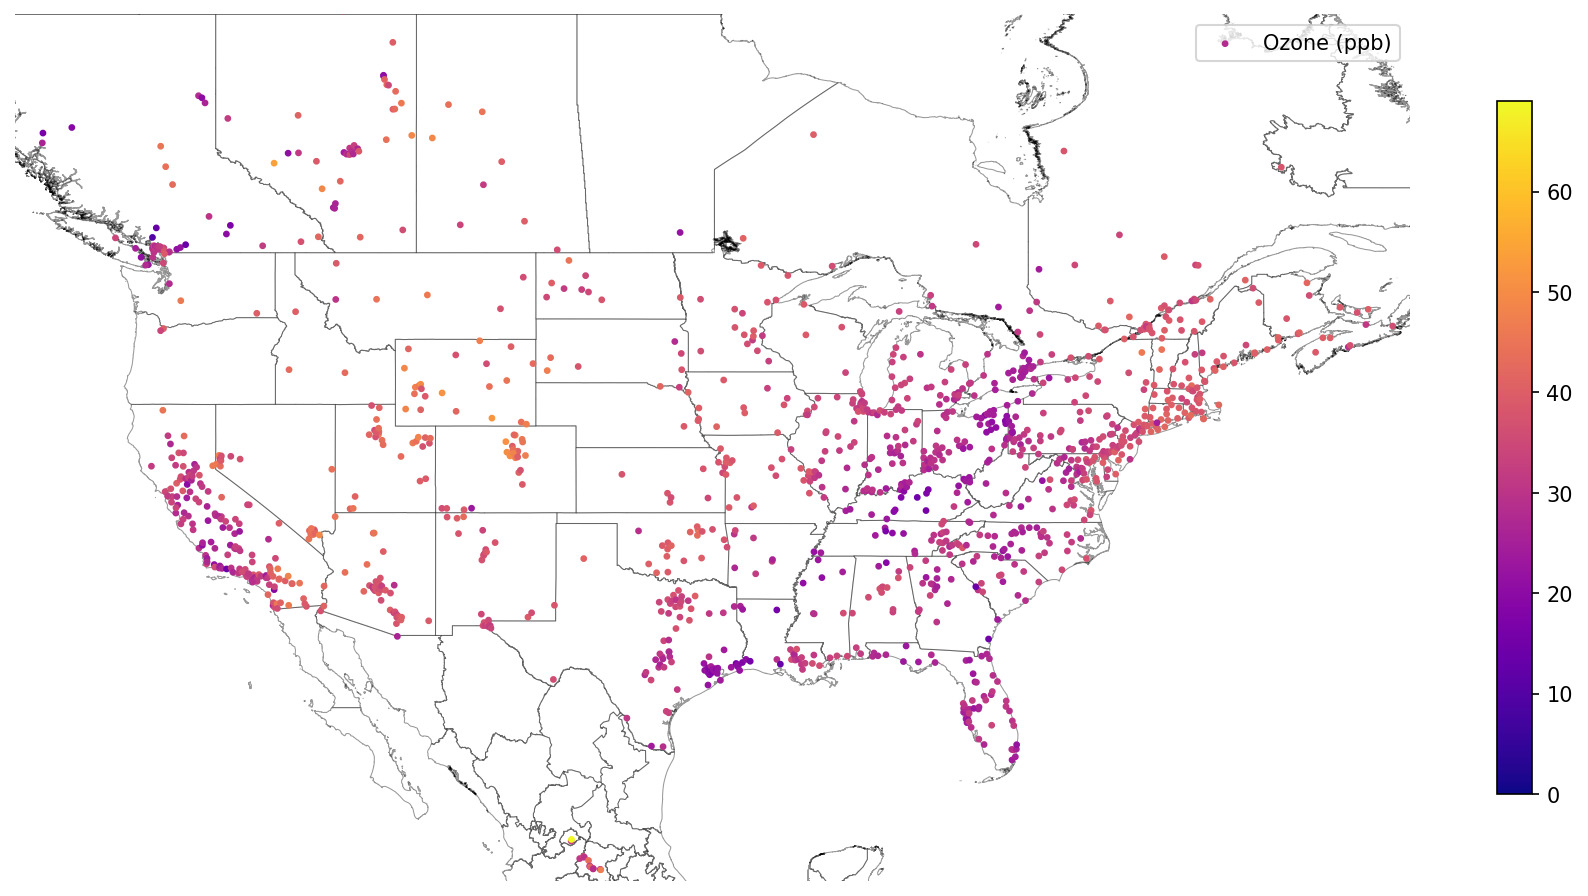

In [10]:
fig, ax = plt.subplots(figsize=(15,15),dpi=150)
me_map.plot(ax=ax, alpha=0.4, color="white",edgecolor='black',linewidth = 0.5)
us_map.plot(ax=ax, alpha=0.4, color="white",edgecolor='black',linewidth = 0.5)
ca_map.plot(ax=ax, alpha=0.4, color="white",edgecolor='black',linewidth = 0.5)
geo_df.plot(ax=ax,column = 'Value_OZONE',cmap = 'plasma', s=5,legend=True,legend_kwds={"shrink":.4},label = 'Ozone (ppb)')
plt.xlim([-130,-60.5])
plt.ylim([20, 60])
plt.legend()
ax.axis("off")
plt.legend()

In [11]:
def get_location_info(row):
    p1 = Point(map(float, (row['Longitude'],row['Latitude'])))
    names = us_map.loc[us_map['geometry'].contains(p1)]['NAME']
    if len(names.unique()) > 1:
        print('Error: Multiple names')
        return None
    elif len(names) < 1:
        return None
    else:
        return names.mode()[0]

In [12]:
df['State'] = df.apply(lambda x: get_location_info(x),axis=1)

In [13]:
sns.set(rc = {'axes.facecolor':'white',
              "axes.edgecolor":'black',    
            "xtick.bottom":True,
            "xtick.top":False,
            "ytick.left":True,
            "ytick.right":False,
            "axes.linewidth":0.2,
            "xtick.major.width":0.2,
            "ytick.major.width":0.2,
            "xtick.minor.width":0.2,
            "ytick.minor.width":0.2,
            "font.size":10,
            "axes.labelsize":10,
            "axes.titlesize":10,
            "xtick.labelsize":10,
            "ytick.labelsize":10,
            "legend.fontsize":10,
            "legend.title_fontsize":10,
            "lines.linewidth":1,
            "patch.linewidth":0.2,
            "patch.edgecolor":'black',
            "patch.force_edgecolor":True,
            "xtick.major.size":3,
            "ytick.major.size":3,
            "xtick.minor.size":1,
            "ytick.minor.size":1,
            "xtick.minor.width":0.2,
            "ytick.minor.width":0.2})

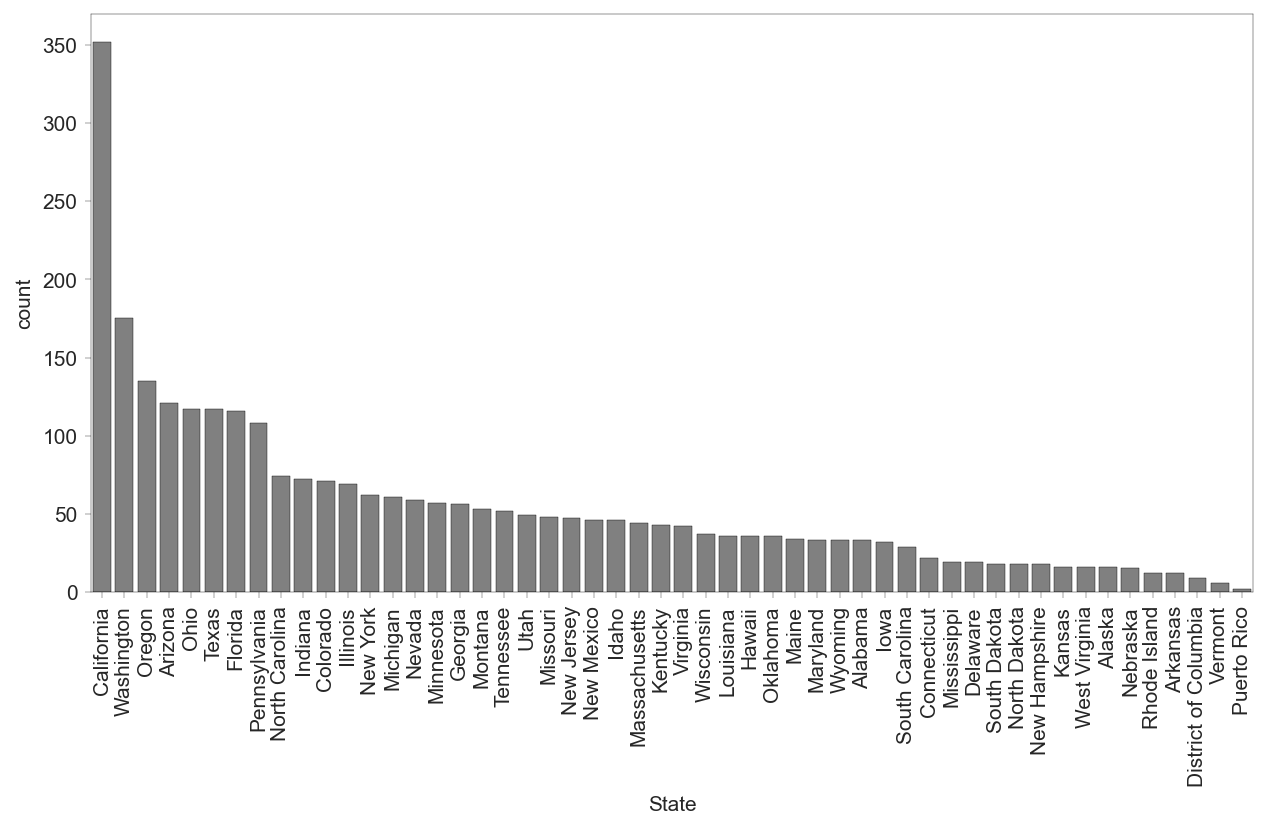

In [14]:
plt.figure(figsize=(10,5),dpi=150)
sns.countplot(data=df, x='State',order=df['State'].value_counts().index, color='grey',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

### Try to query the S3 bucket to verify data is there.

In [15]:
%%time
load_dotenv()
API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")
s3 = boto3.client('s3',aws_access_key_id = API_KEY,aws_secret_access_key= API_SECRET)
bucket='airnow-s3'
result = s3.list_objects(Bucket = bucket)

df = pd.DataFrame()
for o in result.get('Contents'):
 
    data = s3.get_object(Bucket=bucket, Key=o.get('Key'))
    contents = data['Body'].read()
    Dict = contents.decode("utf-8")
    df = pd.concat([df,pd.DataFrame(json.loads(Dict))],ignore_index=True)

print(len(df))
df = df.drop_duplicates()
print(len(df))

1613758
1053374
CPU times: total: 40.8 s
Wall time: 2min 35s


In [16]:
%%time
df = df.sort_values(by='Latitude')
df['State'] = df.apply(lambda x: get_location_info(x),axis=1)

CPU times: total: 34min 14s
Wall time: 51min 14s


In [17]:
df['UTC']  = pd.to_datetime(df['UTC'])
df['PST'] = df['UTC'].dt.tz_localize('utc').dt.tz_convert('US/Pacific')
df['PST'] = df['PST'].dt.strftime("%Y/%m/%d %H:%M")

(0.0, 60.0)

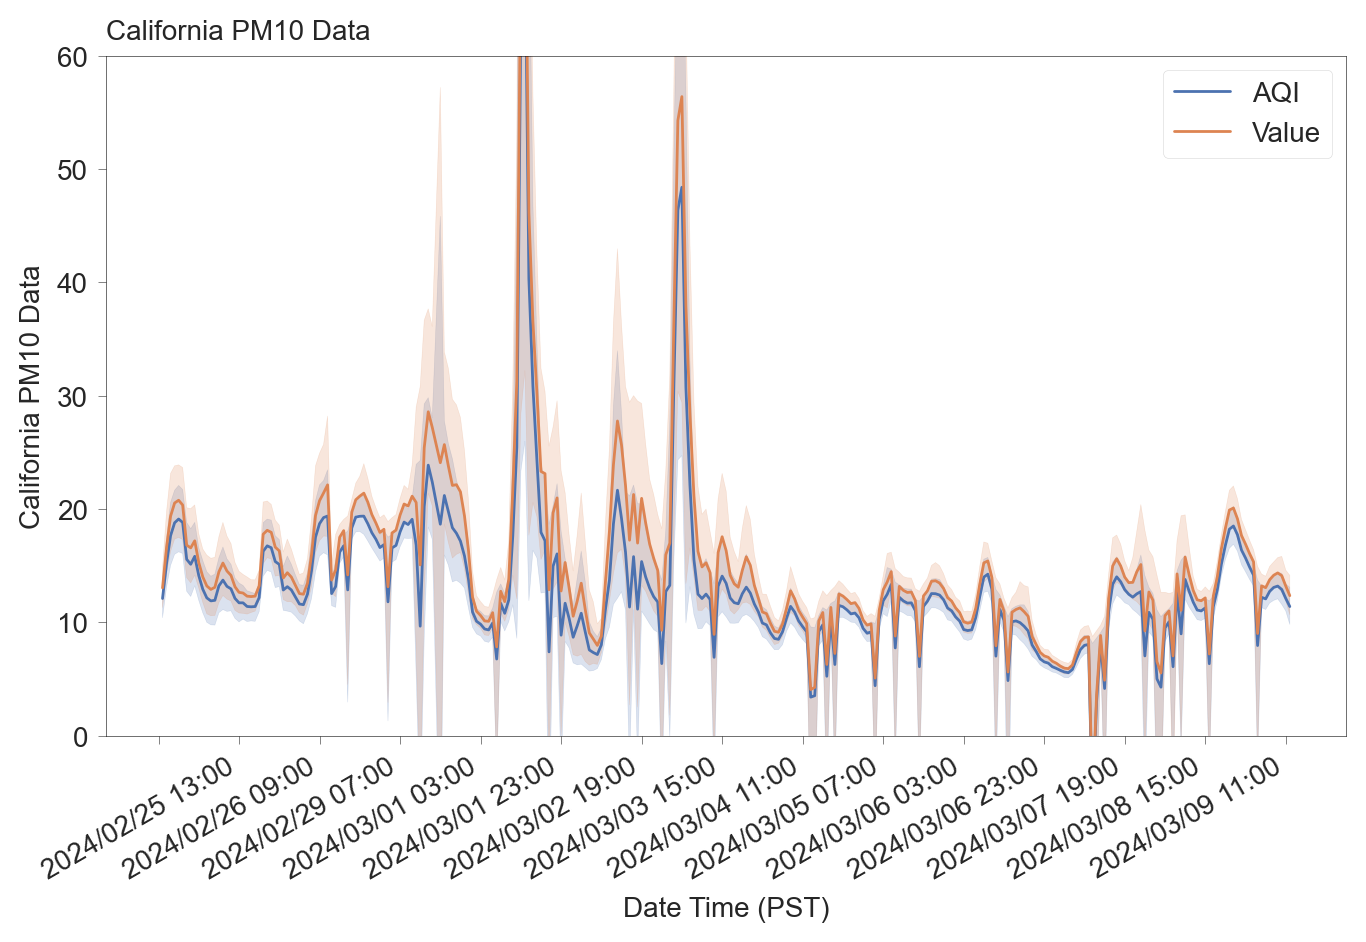

In [25]:
plt.figure(figsize=(8,5),dpi=200)
df = df.sort_values(by='UTC')
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='AQI_PM10',label='AQI')
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='Value_PM10',label='Value')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.legend()
plt.ylabel('California PM10 Data')
plt.title('California PM10 Data',loc='left')
plt.xlabel('Date Time (PST)')
plt.ylim([0,60])

(0.0, 60.0)

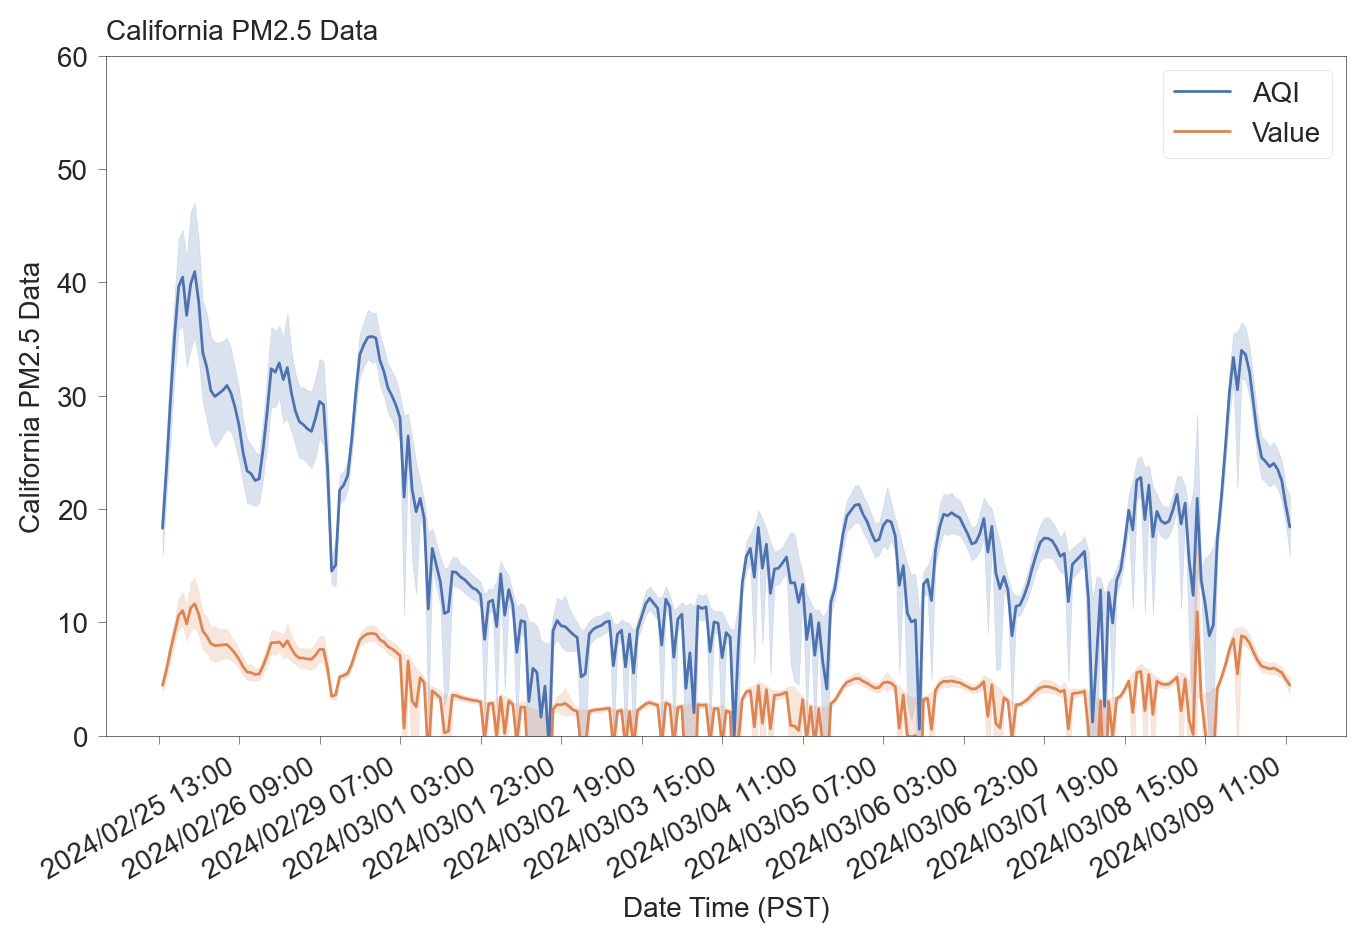

In [29]:
plt.figure(figsize=(8,5),dpi=200)
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='AQI_PM2.5',label='AQI')
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='Value_PM2.5',label='Value')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.legend()
plt.ylabel('California PM2.5 Data')
plt.title('California PM2.5 Data',loc='left')
plt.xlabel('Date Time (PST)')
plt.ylim([0,60])

(0.0, 60.0)

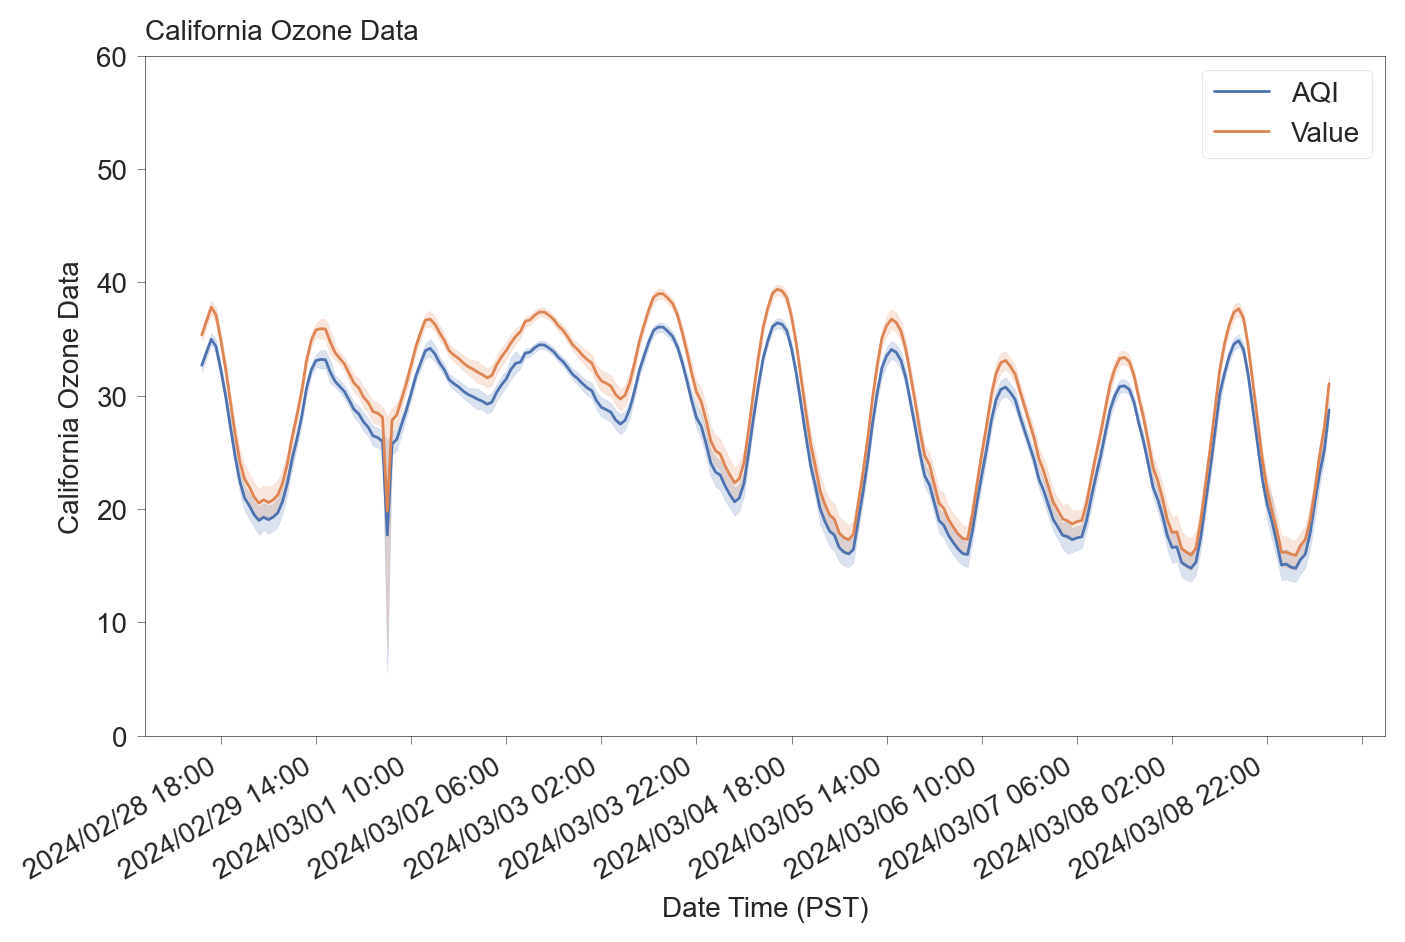

In [30]:
plt.figure(figsize=(8,5),dpi=200)
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='AQI_OZONE',label='AQI')
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='Value_OZONE',label='Value')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.legend()
plt.ylabel('California Ozone Data')
plt.title('California Ozone Data',loc='left')
plt.xlabel('Date Time (PST)')
plt.ylim([0,60])

(0.0, 60.0)

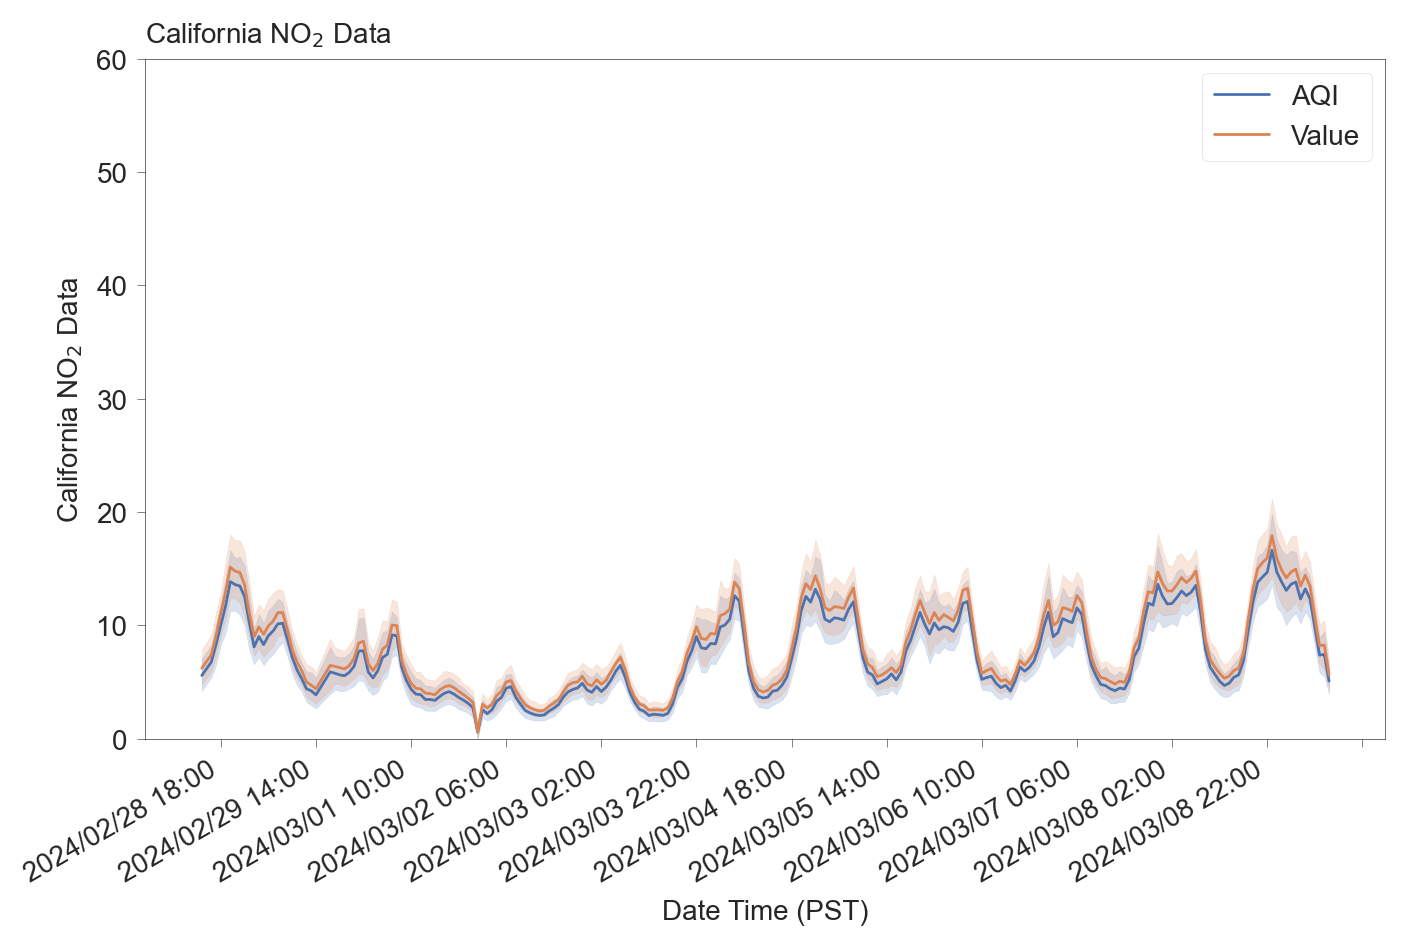

In [31]:
plt.figure(figsize=(8,5),dpi=200)
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='AQI_NO2',label='AQI')
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='Value_NO2',label='Value')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.legend()
plt.ylabel('California NO$_2$ Data')
plt.title('California NO$_2$ Data',loc='left')
plt.xlabel('Date Time (PST)')
plt.ylim([0,60])

(0.0, 5.0)

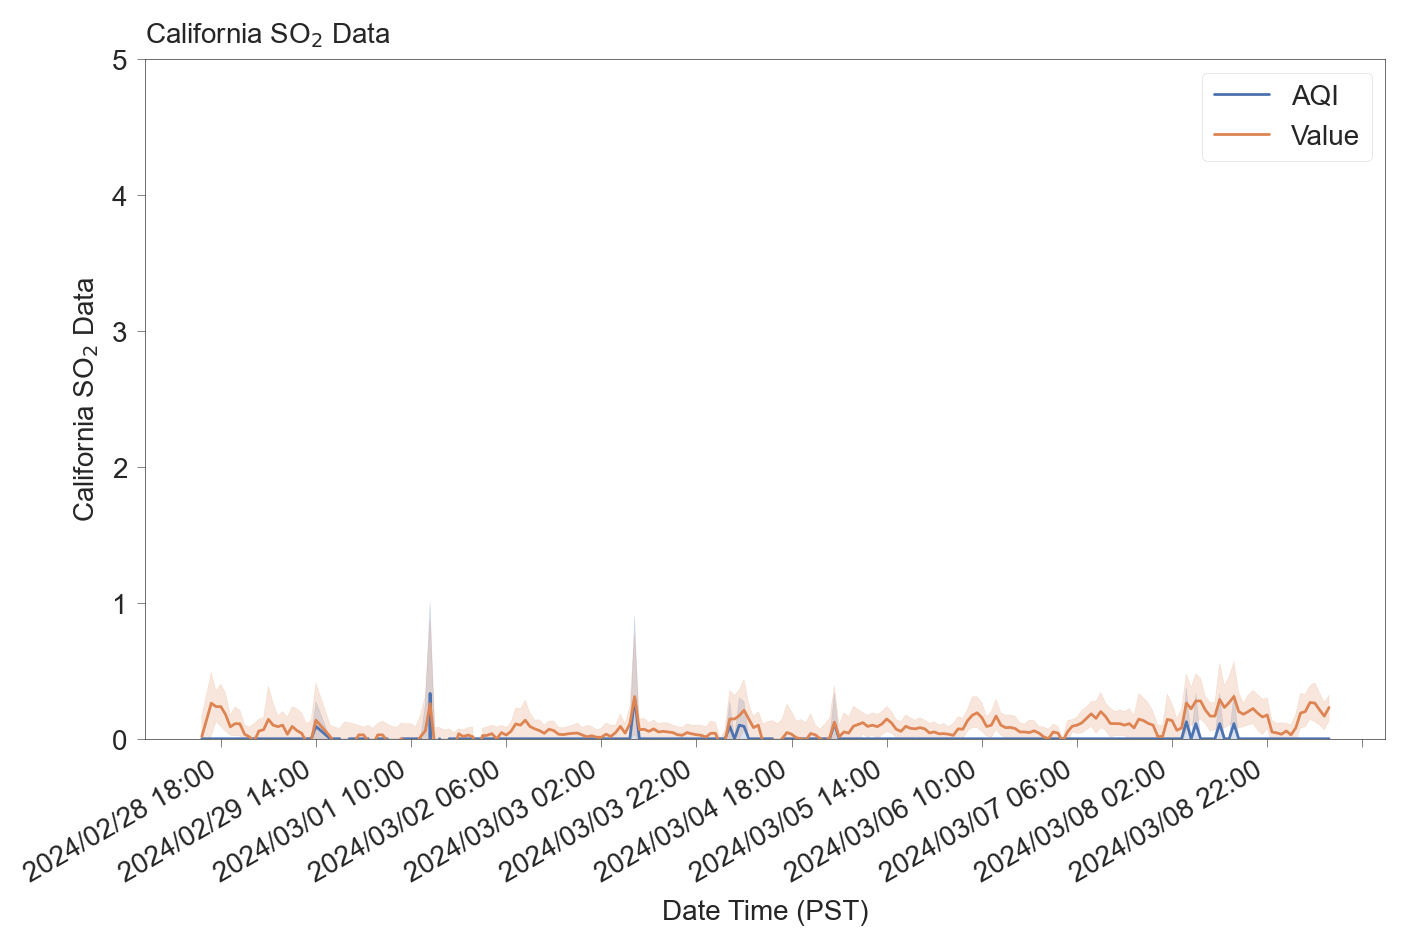

In [32]:
plt.figure(figsize=(8,5),dpi=200)
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='AQI_SO2',label='AQI')
sns.lineplot(data=df.loc[df['State']=='California'], x ='PST',y='Value_SO2',label='Value')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.legend()
plt.ylabel('California SO$_2$ Data')
plt.title('California SO$_2$ Data',loc='left')
plt.xlabel('Date Time (PST)')
plt.ylim([0,5])

Text(0.5, 0, 'Air Quality Index')

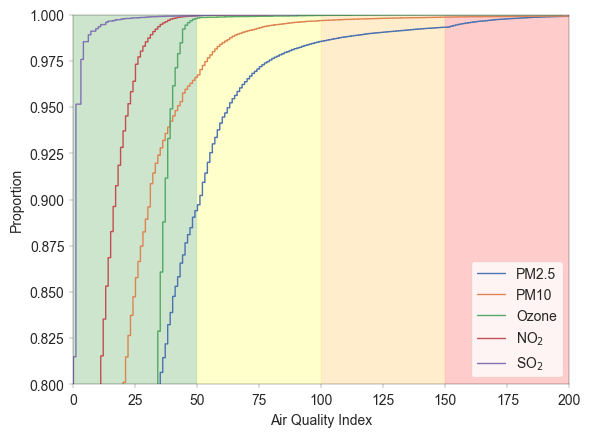

In [33]:
sns.ecdfplot(data=df, x='AQI_PM2.5',label='PM2.5')
sns.ecdfplot(data=df, x='AQI_PM10',label='PM10')
sns.ecdfplot(data=df, x='AQI_OZONE',label='Ozone')
sns.ecdfplot(data=df, x='AQI_NO2',label='NO$_2$')
sns.ecdfplot(data=df, x='AQI_SO2',label='SO$_2$')
plt.axvspan(0, 50, alpha=0.2, color='green')
plt.axvspan(50, 100, alpha=0.2, color='yellow')
plt.axvspan(100, 150, alpha=0.2, color='orange')
plt.axvspan(150, 200, alpha=0.2, color='red')
plt.legend()
plt.xlim([0, 200])
plt.ylim([0.8, 1])
plt.xlabel('Air Quality Index')